# Notebook 03: Phylogenetic Controls & Publication Figures

**Project**: Lifestyle-Based COG Stratification

**Goal**: Control for phylogenetic confounders, test robustness of findings, and generate publication-quality figures.

**Input**:
- `../data/species_lifestyle_classification.csv` (from NB 01)
- `../data/cog_enrichment_by_lifestyle.csv` (from NB 02)
- `../data/cog_lifestyle_stats.csv` (from NB 02)

**Output**: `../figures/lifestyle_cog_heatmap.png`, `../figures/core_fraction_comparison.png`, `../figures/phylum_stratified.png`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10

In [2]:
# Load data from previous notebooks
species_df = pd.read_csv('../data/species_lifestyle_classification.csv')
enrichment = pd.read_csv('../data/cog_enrichment_by_lifestyle.csv')
stats_df = pd.read_csv('../data/cog_lifestyle_stats.csv')

print(f"Species: {len(species_df)}")
print(f"Enrichment rows: {len(enrichment):,}")
print(f"\nLifestyle distribution:")
print(species_df['species_lifestyle'].value_counts())
print(f"\nPhylum distribution:")
print(species_df['phylum'].value_counts().head(10))

Species: 2529
Enrichment rows: 53,339

Lifestyle distribution:
species_lifestyle
host_associated    1705
free_living         824
Name: count, dtype: int64

Phylum distribution:
phylum
p__Pseudomonadota      859
p__Bacillota_A         361
p__Bacteroidota        316
p__Bacillota           314
p__Actinomycetota      272
p__Campylobacterota     53
p__Cyanobacteriota      49
p__Spirochaetota        34
p__Bacillota_C          31
p__Patescibacteria      31
Name: count, dtype: int64


## 1. Phylum-Stratified Analysis

The strongest confounder is phylogeny: if host-associated bacteria cluster in specific phyla,
observed COG differences might reflect phylogeny, not lifestyle.

Test: Do the lifestyle-COG patterns hold **within** individual phyla?

In [3]:
# Identify phyla with enough species in BOTH lifestyle categories
phylum_lifestyle = species_df.groupby(['phylum', 'species_lifestyle']).size().reset_index(name='count')
phylum_wide = phylum_lifestyle.pivot(index='phylum', columns='species_lifestyle', values='count').fillna(0)

# Require >= 5 species in each lifestyle per phylum
MIN_PER_GROUP = 5
testable_phyla = phylum_wide[
    (phylum_wide.get('host_associated', 0) >= MIN_PER_GROUP)
    & (phylum_wide.get('free_living', 0) >= MIN_PER_GROUP)
].index.tolist()

print(f"Phyla testable (>= {MIN_PER_GROUP} species in each lifestyle): {len(testable_phyla)}")
for p in testable_phyla:
    n_h = int(phylum_wide.loc[p, 'host_associated'])
    n_f = int(phylum_wide.loc[p, 'free_living'])
    print(f"  {p}: {n_h} host-associated, {n_f} free-living")

Phyla testable (>= 5 species in each lifestyle): 10
  p__Actinomycetota: 174 host-associated, 98 free-living
  p__Bacillota: 264 host-associated, 50 free-living
  p__Bacillota_A: 356 host-associated, 5 free-living
  p__Bacteroidota: 236 host-associated, 80 free-living
  p__Campylobacterota: 45 host-associated, 8 free-living
  p__Cyanobacteriota: 10 host-associated, 39 free-living
  p__Desulfobacterota: 6 host-associated, 9 free-living
  p__Pseudomonadota: 511 host-associated, 348 free-living
  p__Spirochaetota: 28 host-associated, 6 free-living
  p__Verrucomicrobiota: 9 host-associated, 16 free-living


In [4]:
# Run within-phylum tests for key COG categories
key_cogs = ['V', 'L', 'X', 'E', 'G', 'C', 'P', 'I', 'J', 'M', 'K', 'T']

phylum_results = []
for phylum in testable_phyla:
    phylum_enrich = enrichment[enrichment['phylum'] == phylum]
    for cog in key_cogs:
        host_vals = phylum_enrich[
            (phylum_enrich['COG_category'] == cog) & (phylum_enrich['species_lifestyle'] == 'host_associated')
        ]['enrichment_score']
        free_vals = phylum_enrich[
            (phylum_enrich['COG_category'] == cog) & (phylum_enrich['species_lifestyle'] == 'free_living')
        ]['enrichment_score']
        
        if len(host_vals) >= 3 and len(free_vals) >= 3:
            stat, pval = stats.mannwhitneyu(host_vals, free_vals, alternative='two-sided')
            phylum_results.append({
                'phylum': phylum,
                'COG_category': cog,
                'n_host': len(host_vals),
                'n_free': len(free_vals),
                'median_host': host_vals.median(),
                'median_free': free_vals.median(),
                'diff_median': host_vals.median() - free_vals.median(),
                'p_value': pval
            })

phylum_stats = pd.DataFrame(phylum_results)
if len(phylum_stats) > 0:
    # Direction consistency: does the sign of diff_median match the overall result?
    overall_direction = stats_df.set_index('COG_category')['diff_median'].to_dict()
    phylum_stats['overall_direction'] = phylum_stats['COG_category'].map(
        lambda c: 'pos' if overall_direction.get(c, 0) > 0 else 'neg'
    )
    phylum_stats['same_direction'] = (
        (phylum_stats['diff_median'] > 0) == (phylum_stats['overall_direction'] == 'pos')
    )
    
    print("\n=== Within-Phylum Consistency ===")
    consistency = phylum_stats.groupby('COG_category')['same_direction'].mean()
    for cog in key_cogs:
        if cog in consistency.index:
            print(f"  {cog}: {consistency[cog]:.0%} of phyla show same direction as overall")

phylum_stats.head(20)


=== Within-Phylum Consistency ===
  V: 80% of phyla show same direction as overall
  L: 70% of phyla show same direction as overall
  E: 90% of phyla show same direction as overall
  G: 90% of phyla show same direction as overall
  C: 70% of phyla show same direction as overall
  P: 90% of phyla show same direction as overall
  I: 90% of phyla show same direction as overall
  J: 70% of phyla show same direction as overall
  M: 80% of phyla show same direction as overall
  K: 100% of phyla show same direction as overall
  T: 80% of phyla show same direction as overall


,phylum,COG_category,n_host,n_free,median_host,median_free,diff_median,p_value,overall_direction,same_direction
0,p__Actinomycetota,V,174,98,1.183011,0.447686,0.735325,1.023489e-14,pos,True
1,p__Actinomycetota,L,174,98,1.493993,1.118973,0.375020,1.923396e-04,pos,True
2,p__Actinomycetota,E,174,98,-0.285651,-0.065565,-0.220086,4.694577e-11,neg,True
3,p__Actinomycetota,G,174,98,-0.045992,-0.008140,-0.037852,7.991260e-01,neg,True
4,p__Actinomycetota,C,174,98,-0.231173,0.036031,-0.267204,4.399847e-11,neg,True
5,p__Actinomycetota,P,174,98,-0.166878,0.074314,-0.241191,3.863584e-09,neg,True
6,p__Actinomycetota,I,174,98,-0.255498,-0.093887,-0.161611,1.288552e-06,neg,True
7,p__Actinomycetota,J,174,98,-0.648181,-0.303898,-0.344284,3.039622e-14,neg,True
8,p__Actinomycetota,M,174,98,0.209662,0.020444,0.189218,6.973374e-03,neg,False
9,p__Actinomycetota,K,174,98,0.103200,-0.034958,0.138158,3.943543e-08,pos,True


## 2. Confounder Analysis

Test whether genome count, genome size, or annotation completeness confound the lifestyle signal.

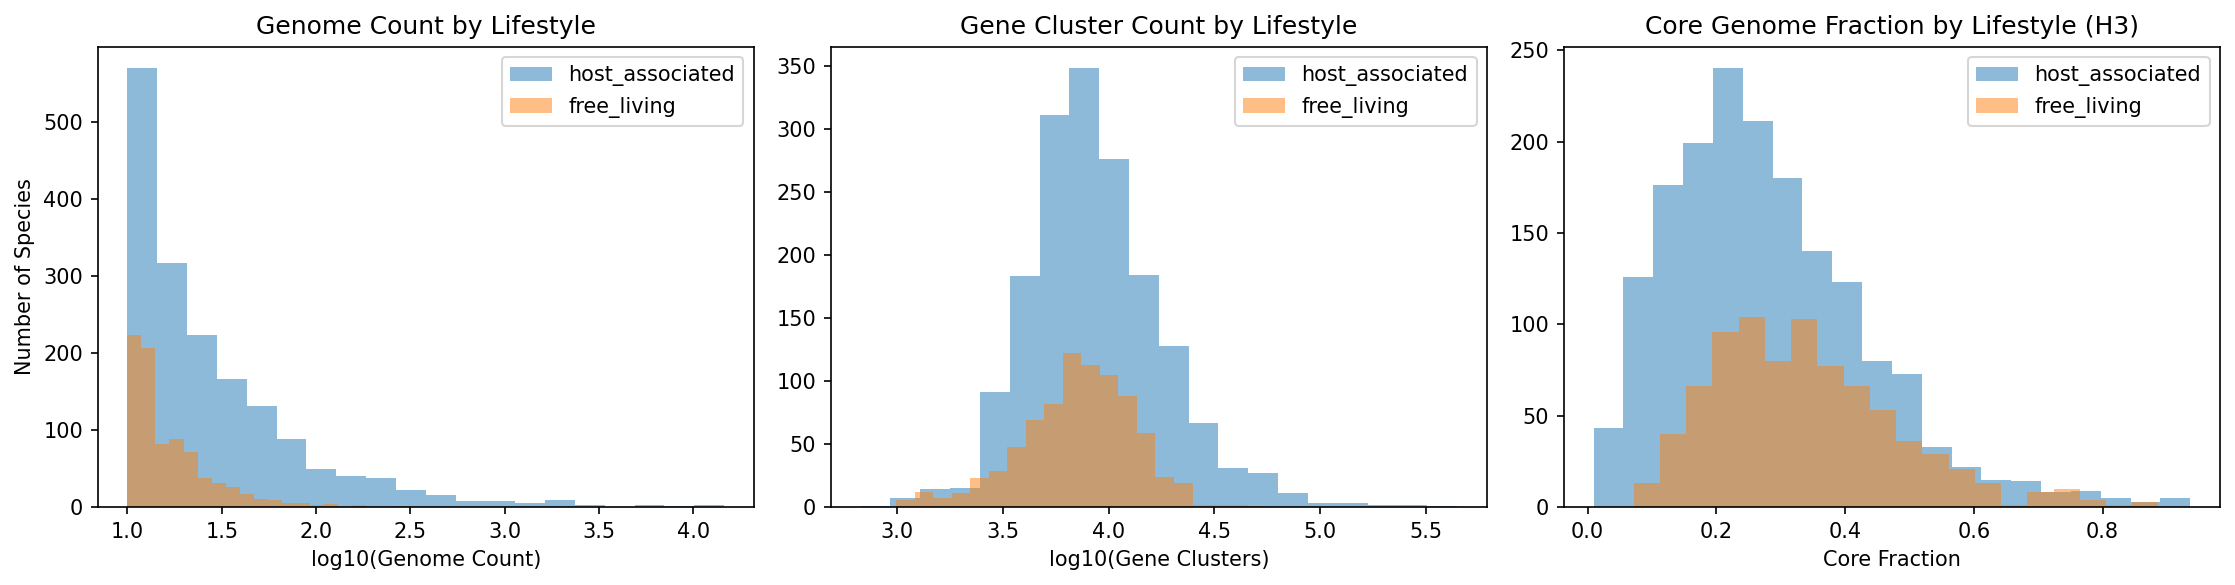

Saved: ../figures/core_fraction_comparison.png


In [5]:
# Compare genome count distribution between lifestyles
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Genome count
for lifestyle in ['host_associated', 'free_living']:
    subset = species_df[species_df['species_lifestyle'] == lifestyle]
    axes[0].hist(np.log10(subset['no_genomes']), alpha=0.5, label=lifestyle, bins=20)
axes[0].set_xlabel('log10(Genome Count)')
axes[0].set_ylabel('Number of Species')
axes[0].set_title('Genome Count by Lifestyle')
axes[0].legend()

# Gene cluster count (proxy for genome size)
for lifestyle in ['host_associated', 'free_living']:
    subset = species_df[species_df['species_lifestyle'] == lifestyle]
    axes[1].hist(np.log10(subset['no_gene_clusters']), alpha=0.5, label=lifestyle, bins=20)
axes[1].set_xlabel('log10(Gene Clusters)')
axes[1].set_title('Gene Cluster Count by Lifestyle')
axes[1].legend()

# Core fraction
species_df['core_fraction'] = species_df['no_core'] / species_df['no_gene_clusters']
for lifestyle in ['host_associated', 'free_living']:
    subset = species_df[species_df['species_lifestyle'] == lifestyle]
    axes[2].hist(subset['core_fraction'], alpha=0.5, label=lifestyle, bins=20)
axes[2].set_xlabel('Core Fraction')
axes[2].set_title('Core Genome Fraction by Lifestyle (H3)')
axes[2].legend()

plt.tight_layout()
plt.savefig('../figures/core_fraction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: ../figures/core_fraction_comparison.png")

In [6]:
# Statistical test for confounders
host = species_df[species_df['species_lifestyle'] == 'host_associated']
free = species_df[species_df['species_lifestyle'] == 'free_living']

print("=== Confounder Comparison ===")
for col, label in [('no_genomes', 'Genome count'), ('no_gene_clusters', 'Gene clusters'), ('core_fraction', 'Core fraction')]:
    stat, pval = stats.mannwhitneyu(host[col].dropna(), free[col].dropna(), alternative='two-sided')
    print(f"{label:20s}: host median={host[col].median():.1f}, free median={free[col].median():.1f}, p={pval:.4e}")

=== Confounder Comparison ===
Genome count        : host median=20.0, free median=14.0, p=5.1170e-35
Gene clusters       : host median=8006.0, free median=7480.5, p=3.8308e-06
Core fraction       : host median=0.3, free median=0.3, p=1.3364e-23


## 3. Publication Figure: Lifestyle COG Heatmap

Side-by-side heatmap showing median enrichment scores for all COG categories,
split by lifestyle, with significance markers.

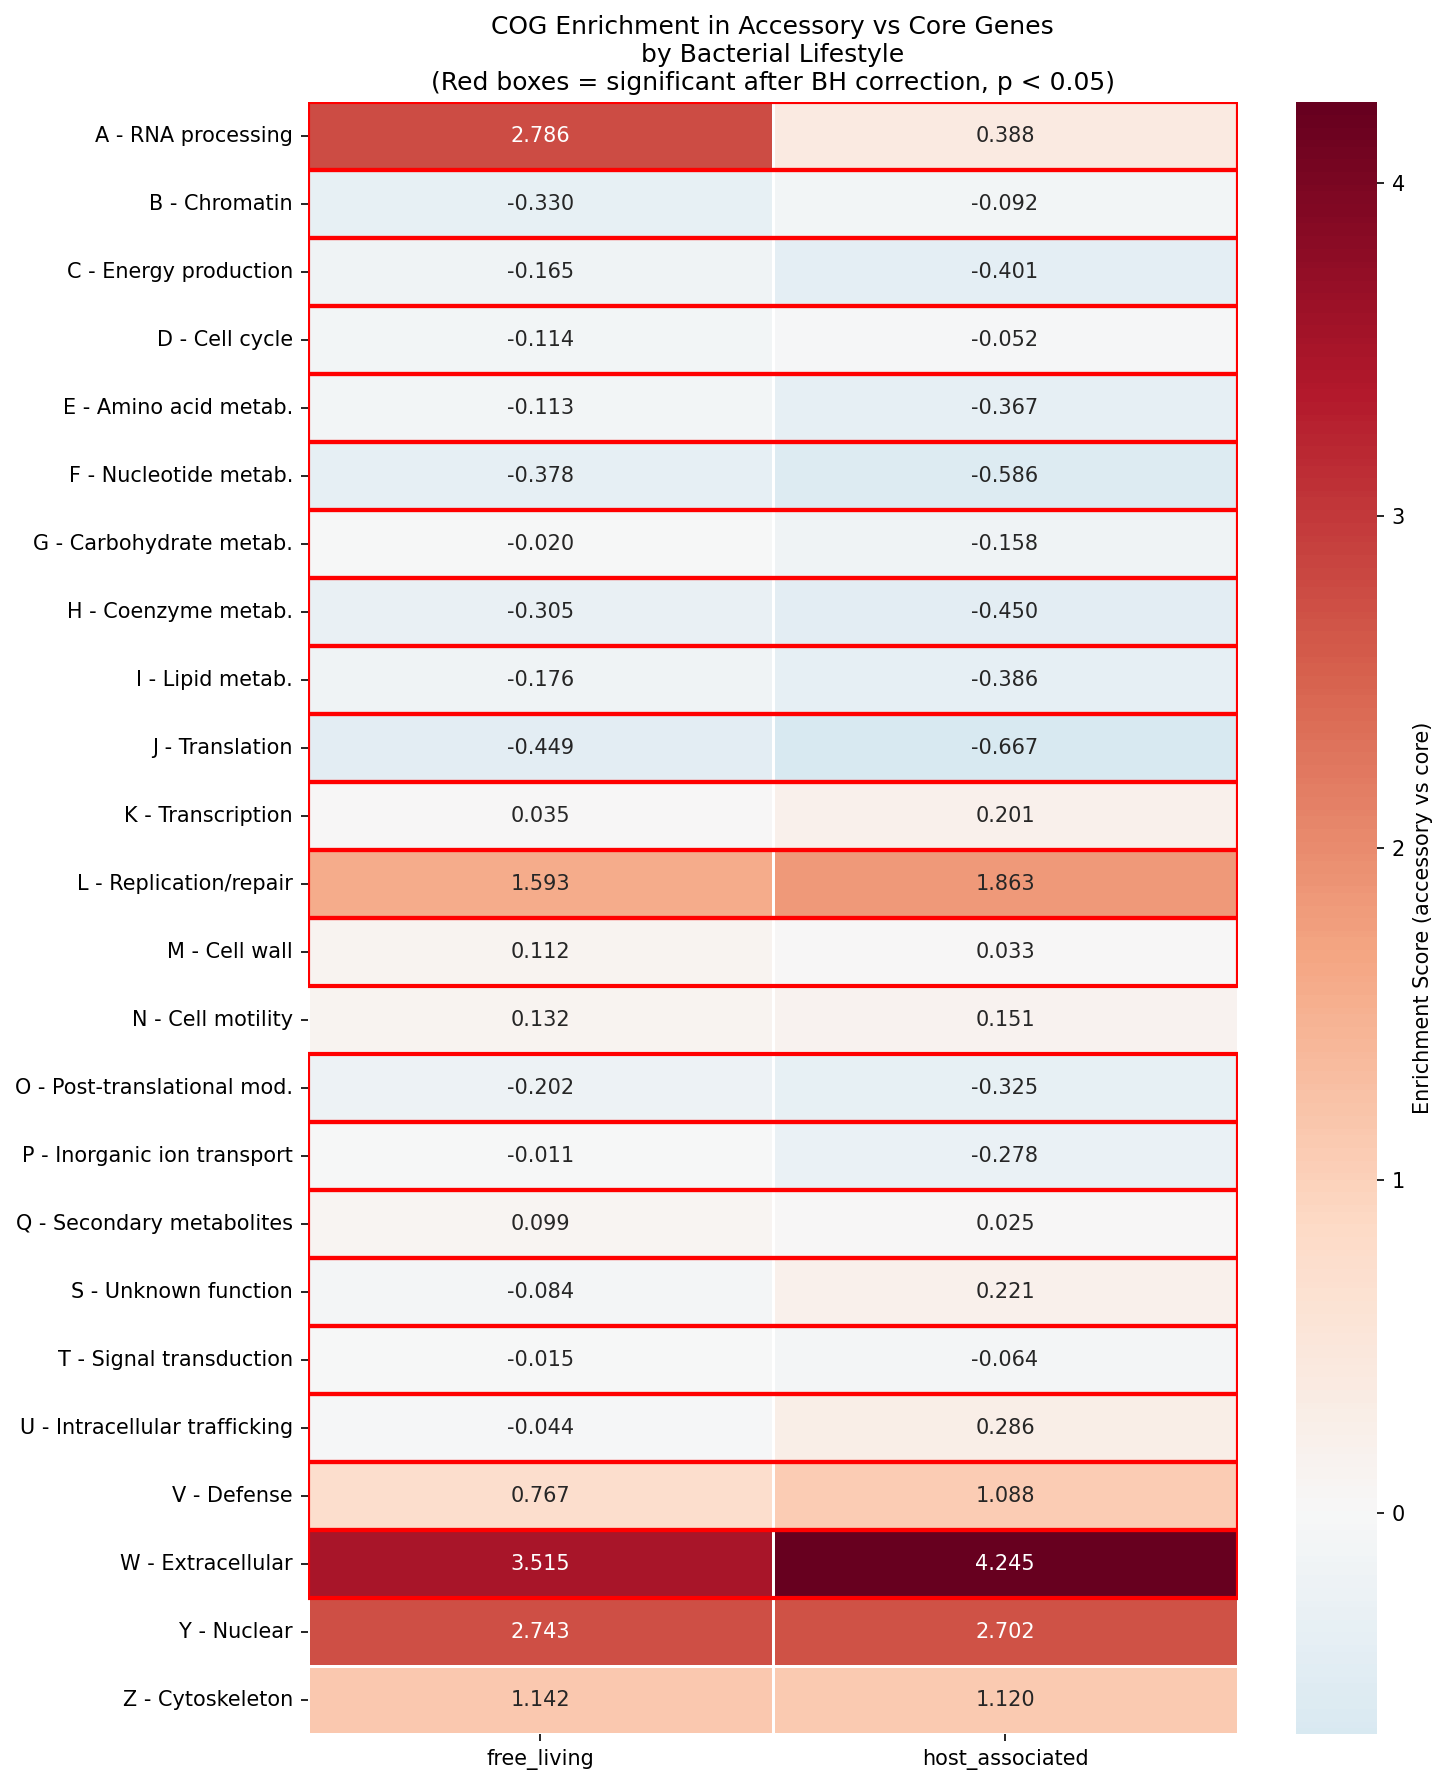

Saved: ../figures/lifestyle_cog_heatmap.png


In [7]:
# COG category descriptions
cog_descriptions = {
    'J': 'Translation', 'A': 'RNA processing', 'K': 'Transcription',
    'L': 'Replication/repair', 'B': 'Chromatin', 'D': 'Cell cycle',
    'V': 'Defense', 'T': 'Signal transduction', 'M': 'Cell wall',
    'N': 'Cell motility', 'U': 'Intracellular trafficking',
    'O': 'Post-translational mod.', 'X': 'Mobilome',
    'C': 'Energy production', 'G': 'Carbohydrate metab.',
    'E': 'Amino acid metab.', 'F': 'Nucleotide metab.',
    'H': 'Coenzyme metab.', 'I': 'Lipid metab.',
    'P': 'Inorganic ion transport', 'Q': 'Secondary metabolites',
    'R': 'General prediction', 'S': 'Unknown function',
    'W': 'Extracellular', 'Z': 'Cytoskeleton', 'Y': 'Nuclear'
}

# Build the pivot for the heatmap
pivot = enrichment.groupby(
    ['species_lifestyle', 'COG_category']
)['enrichment_score'].median().reset_index()

pivot_wide = pivot.pivot(index='COG_category', columns='species_lifestyle', values='enrichment_score')
pivot_wide = pivot_wide.reindex(sorted(pivot_wide.index))

# Add descriptions as labels
pivot_wide.index = [f"{c} - {cog_descriptions.get(c, '?')}" for c in pivot_wide.index]

# Mark significant rows
sig_cogs = set(stats_df[stats_df['significant'] == True]['COG_category'])
row_colors = ['#ff6b6b' if c[0] in sig_cogs else '#e0e0e0' for c in pivot_wide.index]

fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    pivot_wide, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
    linewidths=0.5, ax=ax, cbar_kws={'label': 'Enrichment Score (accessory vs core)'}
)

# Highlight significant rows
for i, color in enumerate(row_colors):
    if color == '#ff6b6b':
        ax.add_patch(plt.Rectangle((0, i), pivot_wide.shape[1], 1,
                                    fill=False, edgecolor='red', linewidth=2))

ax.set_title('COG Enrichment in Accessory vs Core Genes\nby Bacterial Lifestyle\n'
             '(Red boxes = significant after BH correction, p < 0.05)', fontsize=12)
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('../figures/lifestyle_cog_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: ../figures/lifestyle_cog_heatmap.png")

## 4. Phylum-Stratified Figure

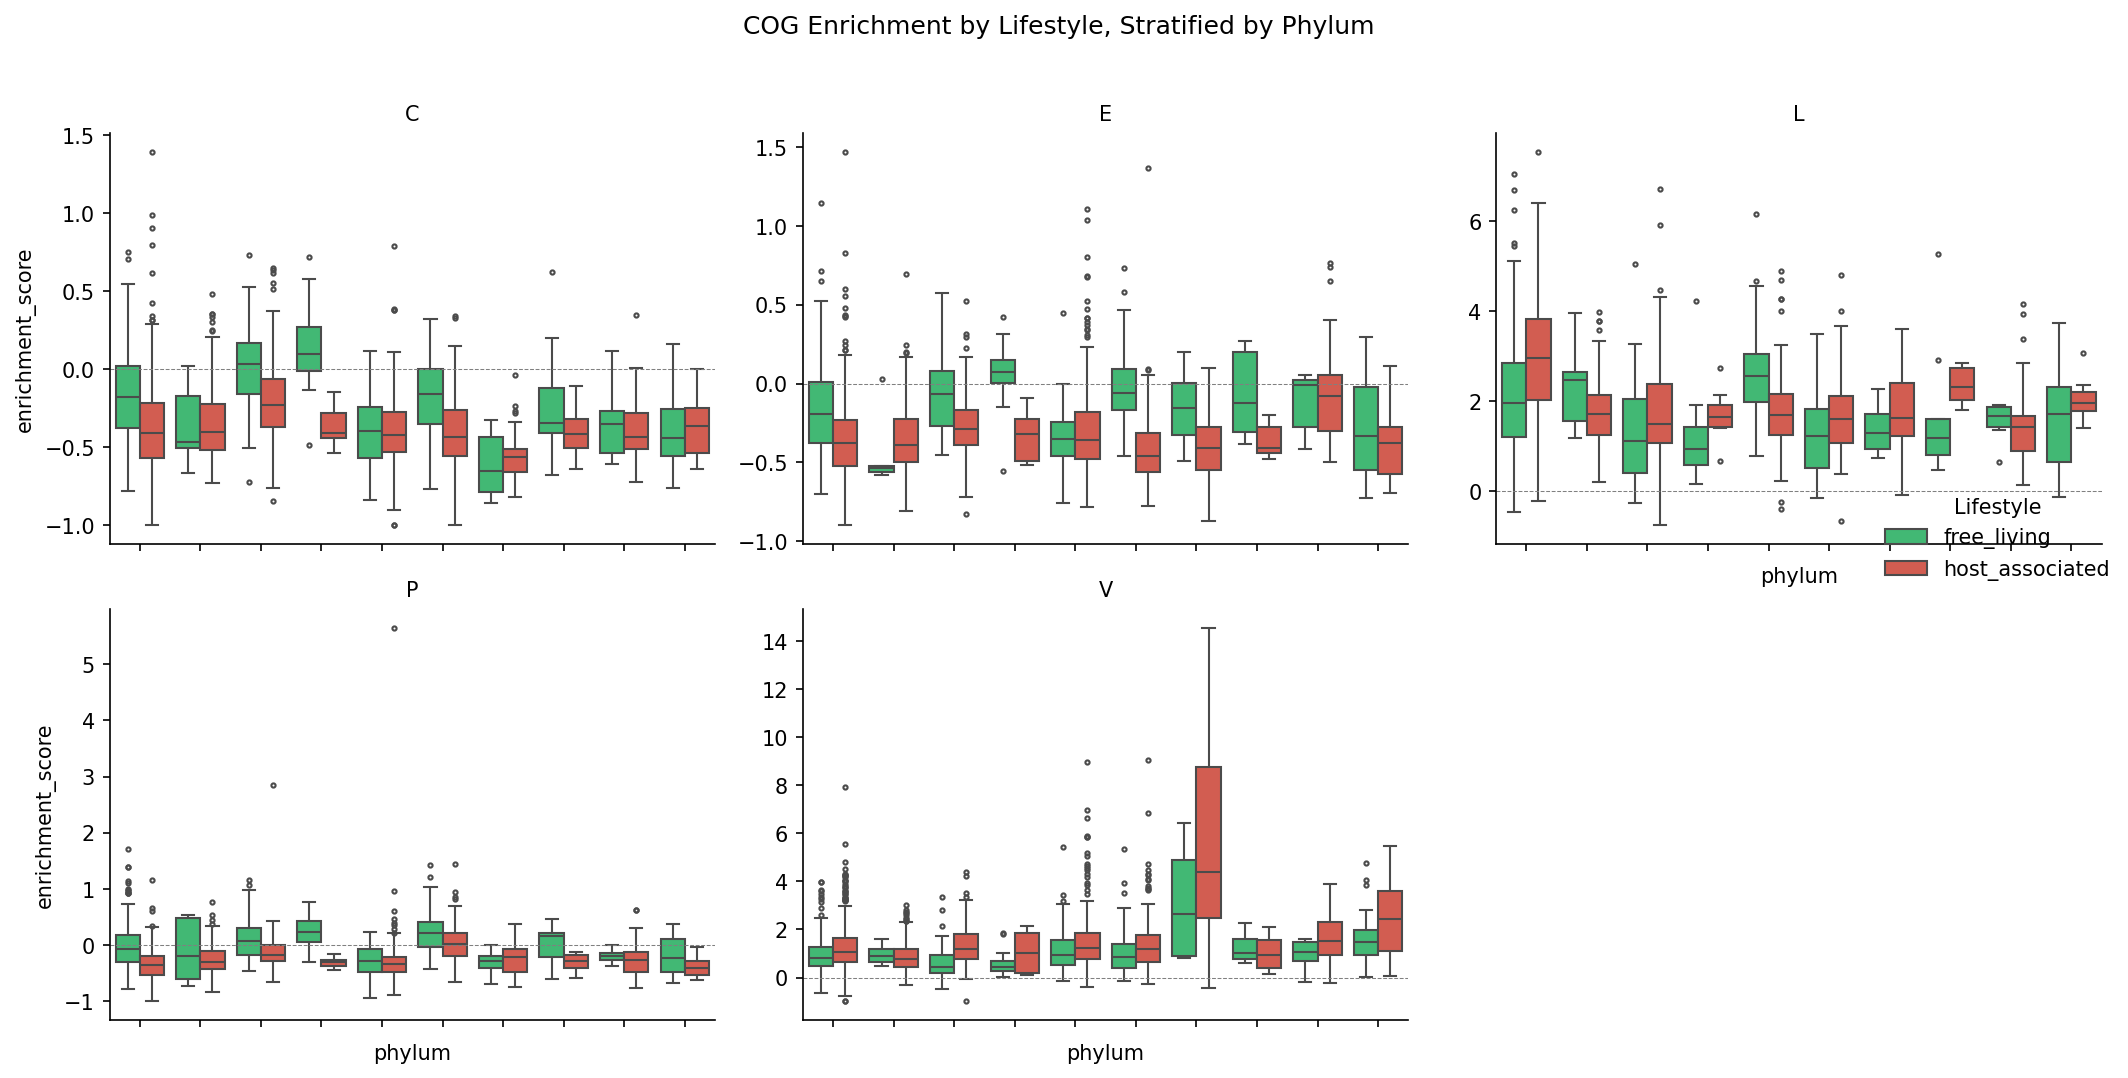

Saved: ../figures/phylum_stratified.png


In [8]:
# Box plots of key COG enrichment scores by lifestyle, stratified by phylum
focus_cogs = ['V', 'L', 'X', 'E', 'C', 'P']
plot_data = enrichment[
    (enrichment['COG_category'].isin(focus_cogs))
    & (enrichment['phylum'].isin(testable_phyla))
]

if len(plot_data) > 0:
    g = sns.FacetGrid(
        plot_data, col='COG_category', col_wrap=3, height=3.5, aspect=1.2,
        sharey=False
    )
    g.map_dataframe(
        sns.boxplot, x='phylum', y='enrichment_score', hue='species_lifestyle',
        palette={'host_associated': '#e74c3c', 'free_living': '#2ecc71'},
        fliersize=2
    )
    g.set_titles(col_template='{col_name}')
    g.set_xticklabels(rotation=45, ha='right')
    for ax in g.axes.flat:
        ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    g.add_legend(title='Lifestyle')
    g.fig.suptitle('COG Enrichment by Lifestyle, Stratified by Phylum', y=1.02)
    plt.tight_layout()
    plt.savefig('../figures/phylum_stratified.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: ../figures/phylum_stratified.png")
else:
    print("Insufficient data for phylum-stratified plot")

## 5. Summary Statistics for Write-up

In [9]:
print("=" * 60)
print("SUMMARY: Lifestyle-Based COG Stratification")
print("=" * 60)
print(f"\nSpecies analyzed: {len(species_df)}")
print(f"  Host-associated: {len(species_df[species_df['species_lifestyle'] == 'host_associated'])}")
print(f"  Free-living:     {len(species_df[species_df['species_lifestyle'] == 'free_living'])}")
print(f"\nPhyla with both lifestyles (>= {MIN_PER_GROUP} each): {len(testable_phyla)}")
print(f"\nCOG categories tested: {len(stats_df)}")
print(f"Significant after BH correction: {stats_df['significant'].sum()}")
print(f"\nSignificant COGs:")
for _, row in stats_df[stats_df['significant'] == True].iterrows():
    direction = 'host > free' if row['diff_median'] > 0 else 'free > host'
    print(f"  {row['COG_category']} ({row['description'][:30]}): {direction}, p_adj={row['p_adjusted']:.2e}")

print(f"\n--- Hypothesis Results ---")
print("H1 (Defense V in host-associated): see stats above")
print("H2 (Metabolic E,G,C,P,I in free-living): see stats above")
print("H3 (Core fraction): see confounder analysis above")

if len(phylum_stats) > 0:
    print(f"\n--- Phylogenetic Robustness ---")
    consistency = phylum_stats.groupby('COG_category')['same_direction'].mean()
    robust = consistency[consistency >= 0.7]
    print(f"COGs with >= 70% direction consistency across phyla: {list(robust.index)}")

SUMMARY: Lifestyle-Based COG Stratification

Species analyzed: 2529
  Host-associated: 1705
  Free-living:     824

Phyla with both lifestyles (>= 5 each): 10

COG categories tested: 24
Significant after BH correction: 21

Significant COGs:
  S (Function unknown): host > free, p_adj=7.81e-117
  E (Amino acid metabolism): free > host, p_adj=9.42e-79
  I (Lipid metabolism): free > host, p_adj=2.22e-78
  J (Translation, ribosomal): free > host, p_adj=2.41e-64
  P (Inorganic ion transport): free > host, p_adj=3.09e-64
  C (Energy production): free > host, p_adj=4.91e-62
  F (Nucleotide metabolism): free > host, p_adj=9.52e-54
  K (Transcription): host > free, p_adj=1.40e-47
  H (Coenzyme metabolism): free > host, p_adj=1.93e-39
  O (Post-translational modificatio): free > host, p_adj=1.36e-34
  U (Intracellular trafficking): host > free, p_adj=1.54e-33
  G (Carbohydrate metabolism): free > host, p_adj=2.37e-24
  V (Defense mechanisms): host > free, p_adj=2.30e-21
  L (Replication, recombin

## Findings

Record final interpretations here after running:

- **Phylogenetic robustness**: Which patterns hold within phyla? ___
- **Confounders**: Do genome count or size differences explain the patterns? ___
- **Overall conclusion**: ___
- **Limitations**: ___
- **Next steps**: ___